In [ ]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision.transforms as transforms
from torchvision import models

from time import time
from PIL import Image
import copy

from skimage import io, transform
from tqdm.notebook import tqdm

from matplotlib import rcParams
rcParams['figure.figsize'] = (13,3)

rescale_size = 300

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #check that our gpu is available
device

device(type='cuda')

In [ ]:
transform_ex = transforms.Compose([
              transforms.Resize(size=(rescale_size, rescale_size)),  # scale imported image
              transforms.ToTensor(),
          ]) 

In [ ]:
def image_loader(image_name):
    return (transform_ex(Image.open(image_name))).unsqueeze(0).to(device, torch.float)   #transform loaded images to tensor batch

style_img = image_loader("starry_night.jpg")
content_img = image_loader("brad_pitt.jpg")

print(style_img.size(), content_img.size())

torch.Size([1, 3, 300, 300]) torch.Size([1, 3, 300, 300])


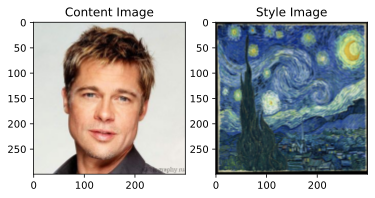

In [ ]:
def imshow(name, title=None):           #lets visuzualise our images
    img = transforms.Resize(size=(rescale_size, rescale_size))(Image.open(name))
    plt.imshow(img)
    if title is not None:
        plt.title(title)


plt.subplot(1, 2, 1)
imshow("brad_pitt.jpg", title='Content Image')

plt.subplot(1, 2, 2)
imshow("starry_night.jpg", title='Style Image')

Для первой пары возьмем известного актера Бреда Пита и картину Ван Гога звездная ночь

Second pair content-style

In [ ]:
style_img = image_loader("meniny.jpg")
content_img = image_loader("street.jpg")

print(style_img.size(), content_img.size())

torch.Size([1, 3, 300, 300]) torch.Size([1, 3, 300, 300])


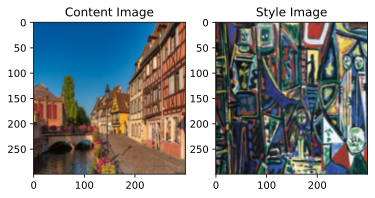

In [ ]:
plt.subplot(1, 2, 1)
imshow("street.jpg", title='Content Image')

plt.subplot(1, 2, 2)
imshow("meniny.jpg", title='Style Image')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Mon Apr 11 11:59:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    60W / 149W |    535MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model_noname = models.vgg19(pretrained=True).features.to(device).eval()  # lets load pretrained vgg and discard classify layers

*We will add content loss module directly after the convolution layers that are being used to compute the content distance. This way each time the network is fed an input image the content losses will be computed at the desired layers and because of auto grad, all the gradients will be computed. Also in order to make the content loss layer transparent we must define a forward method that computes the content loss and then returns the layer’s input. The computed loss is saved as a parameter of the module.*

Функция потерь - это то, что мы пытаемся минимизировать. Стандартный лосс Гатиса задается следующим образом(не учитывая потери полной вариации):
$$\mathcal L_{Gatys}(y, \hat y) = \alpha*\frac{1}{W^{l}H^{l}C^{l}} \|Ф^{l}(x) - Ф^{l}(x_{c})\| + \beta*\frac{1}{C^2_{l}}\|G^{l}(x) - G^{l}(x_{s})\|.$$

Так как сближение матриц грама не гарантирует полной похожести распределений даже в идеальноми случае(как минимум из-за разных средних), потому что матрицы Грама сближают нецентрированные вторые моменты или если говорить более наглядно для одномерного случая можно доказать что сближается норма скалярного произведения среднего на дисперсию,  мы попробуем ввести третью функцию, которая будет также помогать нам сближать распределения, это расстояние Кульбака-Лейблера. В дискретном случае это велична определяется так:
$$\mathcal L_{KL}(P \| Q) = \sum^{n}_i p_i * \log(\frac{p_i}{q_i})  .$$



In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a feature map

    features = input.view(a * b, c * d) 

    G = torch.mm(features, features.t())  # compute the gram product
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
class KLDivrgLoss(nn.Module):
    def __init__(self, target):
          super(KLDivrgLoss, self).__init__()
          # we 'detach' the target content from the tree used
          # to dynamically compute the gradient: this is a stated value,
          # not a variable. Otherwise the forward method of the criterion
          # will throw an error.
          self.target = target.detach()

    def forward(self, input):
          self.loss = F.kl_div(input, torch.transpose(self.target, 2, 3))
          return input

In [ ]:
class KLDivrgLoss1(nn.Module):
    def __init__(self, target):
          super(KLDivrgLoss1, self).__init__()
          # we 'detach' the target content from the tree used
          # to dynamically compute the gradient: this is a stated value,
          # not a variable. Otherwise the forward method of the criterion
          # will throw an error.
          self.target = target.detach()

    def forward(self, input):
          self.loss = F.kl_div(input, self.target)
          return input

In [ ]:
class KLDivrgLoss2(nn.Module):
    def __init__(self, target):
          super(KLDivrgLoss2, self).__init__()
          # we 'detach' the target content from the tree used
          # to dynamically compute the gradient: this is a stated value,
          # not a variable. Otherwise the forward method of the criterion
          # will throw an error.
          self.target = target.detach()

    def forward(self, input):
          self.loss = F.kl_div(input, torch.transpose(self.target, 2, 3))
          return input

In [ ]:
norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
norm_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
content_layers = ['conv_4']
#kl_layers = ['conv_2']
kl1_layers = ['conv_1']
kl2_layers = ['conv_3']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [ ]:
content_losses = []
style_losses = []
#kl_losses = []
kl1_losses = []
kl2_losses = []

In [ ]:
norm = Normalization(norm_mean, norm_std).to(device)
model = nn.Sequential(norm)
i = 0  # increment every time we see a conv
for layer in model_noname.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        # The in-place version doesn't play very nicely with the ContentLoss
        # and StyleLoss we insert below. So we replace with out-of-place
        # ones here.
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)

    model.add_module(name, layer)

    if name in content_layers:
        # add content loss:
        target = model(content_img).detach()
        content_loss = ContentLoss(target)
        model.add_module("content_loss_{}".format(i), content_loss)
        content_losses.append(content_loss)

    if name in style_layers:
        # add style loss:
        target_feature = model(style_img).detach()
        style_loss = StyleLoss(target_feature)
        model.add_module("style_loss_{}".format(i), style_loss)
        style_losses.append(style_loss)
    
    if name in kl1_layers:
        # add kl loss:
        target = model(style_img).detach()
        kl1_loss = KLDivrgLoss1(target)
        model.add_module("kl1_loss_{}".format(i), kl1_loss)
        kl1_losses.append(kl1_loss)

    if name in kl2_layers:
        # add kl loss:
        target = model(style_img).detach()
        kl2_loss = KLDivrgLoss2(target)
        model.add_module("kl2_loss_{}".format(i), kl2_loss)
        kl2_losses.append(kl2_loss)


#now we trim off the layers after the last content and style losses
for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss) or isinstance(model[i], KLDivrgLoss):
        break

model = model[:(i + 1)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


In [ ]:
style_losses

[StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss()]

In [ ]:
kl2_losses

[KLDivrgLoss2()]

In [ ]:
model.requires_grad_(False)

Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (kl1_loss_1): KLDivrgLoss1()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (kl2_loss_3): KLDivrgLoss2()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)

In [ ]:
#900000_21_150_130

In [ ]:
def train(model, opt, content_img, style_img, input_img, max_epoch, style_weight=900000, content_weight=21, kl1_weight=150, kl2_weight=130):  #training loop
    input_img.requires_grad_(True)
    history = []

    run = [0]
    while run[0] <= max_epoch:
    #for epochs in tqdm(range(max_epoch)):
        def closure():
              with torch.no_grad():
                  input_img.clamp_(0, 1)

              opt.zero_grad()  # set parameter gradients to zero
              model(input_img)
              style_loss = 0
              content_loss = 0
              kl_loss = 0

              for sl in style_losses:
                  style_loss += sl.loss * style_weight
              for cl in content_losses:
                  content_loss += cl.loss * content_weight
              for kl1 in kl1_losses:
                  kl_loss += kl1.loss * kl1_weight
              for kl2 in kl2_losses:
                  kl_loss += kl2.loss * kl2_weight   
  

              loss = content_loss + style_loss + kl_loss
              loss.backward()   #backward
              run[0] += 1

              if run[0] % 50 == 0:
                  print('KL Loss : {:4f} Style Loss : {:4f} Content Loss: {:4f}'.format(kl_loss.item(), style_loss.item(), content_loss.item()), end='\n')
                  #print(style_loss)

              history.append((content_loss.item(), style_loss.item(), kl_loss.item()))

              return style_loss + content_loss + kl_loss

        opt.step(closure)    #update weights

    with torch.no_grad():
        input_img.clamp_(0, 1)

    print("run:", run[0])
    return input_img, history

In [ ]:
input_img = content_img.clone()

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 294.487579 Content Loss: 26.588717

run [100]:
Style Loss : 108.936874 Content Loss: 28.710398



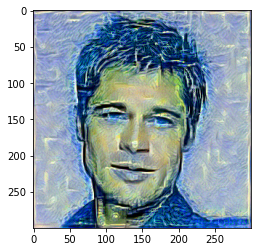

In [ ]:
# output = run_style_transfer(model_noname, cnn_normalization_mean, cnn_normalization_std,
#                             content_img, style_img, input_img)

# plt.figure()
# plt.imshow(transforms.ToPILImage()(output.squeeze(0)))

# plt.show()

In [ ]:
max_epoch = 150
opt = optim.LBFGS([input_img])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


KL Loss : 326.976135 Style Loss : 144.595535 Content Loss: 508.112366
KL Loss : 252.256516 Style Loss : 65.585457 Content Loss: 430.095581
KL Loss : 214.063568 Style Loss : 51.028336 Content Loss: 411.465698
run: 160


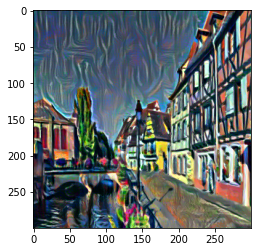

In [ ]:
output, history = train(model, opt, content_img, style_img, input_img, max_epoch)

plt.figure()
plt.imshow(transforms.ToPILImage()(output.squeeze(0)))

plt.show()

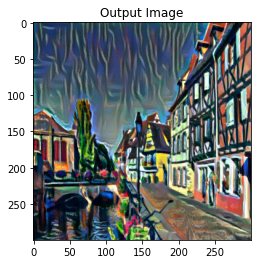



---


## *Conclusion:*

Еще раз выведем первую пару изображений для большей наглядности:

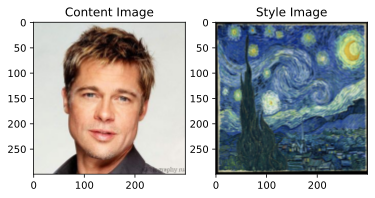

In [ ]:
plt.subplot(1, 2, 1)
imshow("brad_pitt.jpg", title='Content Image')

plt.subplot(1, 2, 2)
imshow("starry_night.jpg", title='Style Image')

Стандартная стилизация:

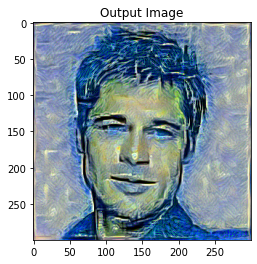

KL divergency loss на 2 сверточном слое с коэффициентом 30:

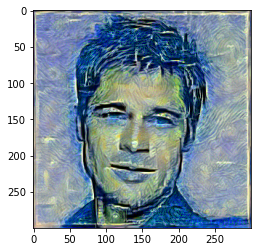

KL divergency loss на 3 сверточном слое с коэффициентом 50:

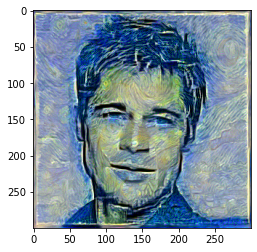

KL divergency loss на 3 сверточном слое с коэффициентом 80:

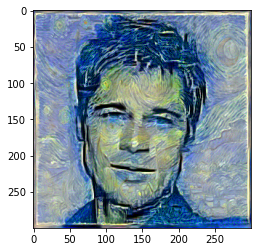

Мы можем видеть что результат работы очень варьируется от слоя на котором посчитан лосс и от коэффициента с котрым взят. Чем с более глубоких слоев считается лосс, тем сильнее KL дивергенция "накладывает" изображения на друга(что абсолютно отражает ее смысл, так как она измеряет насколько одно распределение может быть приближено другим, насколько одно распределение "содержится в другом"), так как сближает более общую информацию, на небольших слоях дает красивые мазки и эффекты, либо почти попиксельный перенос на маленьких.
Экспериментально выяснил, что для 4 слоя изображения сильно накладываются друг на друга(см.рис выше), для 1 слоя эффект почти не заметен, для промежуточных слоев, таких как 2 и 3 при правильном подборе коэффициента дает более приятные результаты, чем стандартная стилизация.
Диверегнция Кульбака-Лейблера была выбрана специально, хотя и не является симметричной, в отличие от дивергенции Йенсена-Шеннона, к примеру, но в данной задаче симметричность нам не требуется, так как мы стараемся приблизить распределение данного изображения к стилевому в некотором промежуточном слое сети при минимальных потерях контента.

Также для визуального усложнения наложения можно использовать транспонированную матрицу в расчетах KL лосса, так как это не изменит общий стиль, а лишь изменит пространственное нахождение тех или иных объектов, лииний, мазков, пикселей

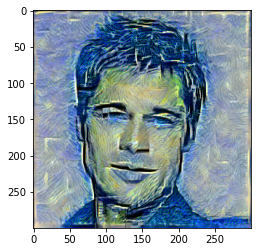

Вторая пара:

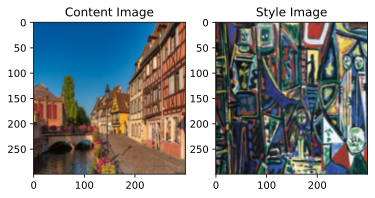

In [ ]:
plt.subplot(1, 2, 1)
imshow("street.jpg", title='Content Image')

plt.subplot(1, 2, 2)
imshow("meniny.jpg", title='Style Image')

Примерно то же самое мы можем видеть на другой входной паре. Контент - улица Французского города Кольмар, стиль - картина Пикассо "Менины". Визуально видно, что наша сеть дает изображению более крупноблочный стиль, не отдельными линиями, что особенно хорошо видно на небе, которое испещрено лииниями в стандартном варианте


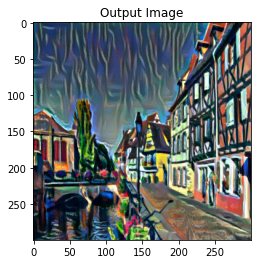
---



Наше изображение:

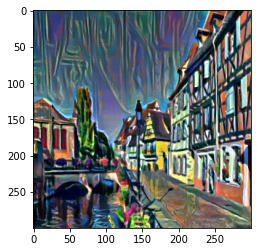

Чтобы меньше привязываться к стилевой картинке и она не накладывалась слишком сильно на контент напрямую можно взять с заранее заданными весами несколько kl лоссов с разных слоев, с начального, где сближается больше попиксельная информация и с глубокого, где переносится крупноблочная информация. Таким образом с одной стороны осталась крупноблочная информаиция(видно на небе), но она уже не так сильно привязана к стилевой картинке и относительно размыта мелкими мазками и лииниями. Результат с весами 250 для 1 сверточного слоя, 200 для третьего:

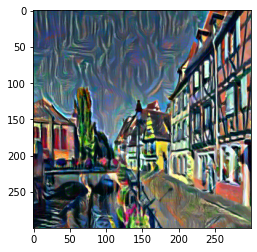

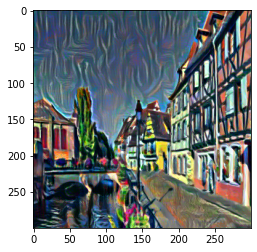

(чуть-чуть ослабим стилизацию)

Таким образом был протестирован дополнительный лосс в виде KL дивергенции, показаны различные результаты стилизаций, было проведено сравнение с стандартным методом гатиса и экспериментально доказано преимущество нашего метода

---



---



In [ ]:
cont_loss, stl_loss = zip(*history)          

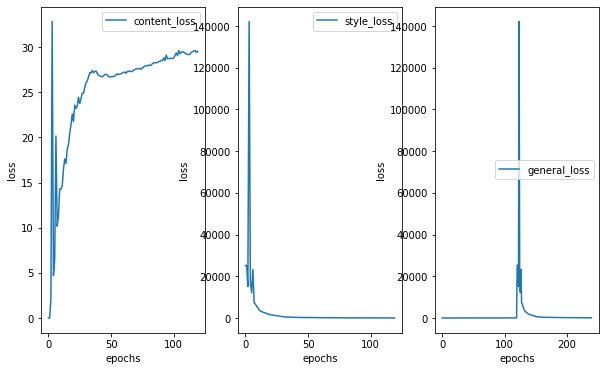

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(131)
plt.plot(cont_loss, label="content_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(132)
plt.plot(stl_loss, label="style_loss")
plt.legend()    
plt.xlabel("epochs")
plt.ylabel("loss")                            

plt.subplot(133)
plt.plot(cont_loss + stl_loss, label="general_loss")
plt.legend()    
plt.xlabel("epochs")
plt.ylabel("loss")                            


plt.show()

In [ ]:
cont_loss, stl_loss, kl_loss = zip(*history)          

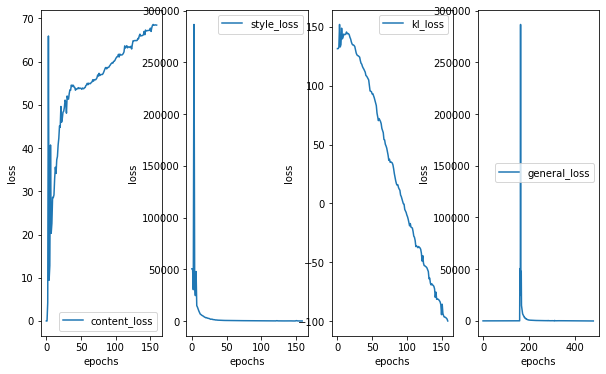

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(141)
plt.plot(cont_loss, label="content_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(142)
plt.plot(stl_loss, label="style_loss")
plt.legend()    
plt.xlabel("epochs")
plt.ylabel("loss")  


plt.subplot(143)
plt.plot(kl_loss, label="kl_loss")
plt.legend()    
plt.xlabel("epochs")
plt.ylabel("loss")  

plt.subplot(144)
plt.plot(cont_loss + stl_loss + kl_loss, label="general_loss")
plt.legend()    
plt.xlabel("epochs")
plt.ylabel("loss")                            


plt.show()